# Data Modelling

## Get the data from the previous notebook

##### Import the libraries

In [109]:
import json
import psycopg2
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

##### Get the data from the previous notebook, as csv files, and load them into dataframes

In [110]:
awards_players_df = pd.read_csv('../prep_data/awards_players_df.csv')
coaches_df = pd.read_csv('../prep_data/coaches_df.csv')
players_df = pd.read_csv('../prep_data/players_df.csv')
players_teams_df = pd.read_csv('../prep_data/players_teams_df.csv')
series_post_df = pd.read_csv('../prep_data/series_post_df.csv')
teams_df = pd.read_csv('../prep_data/prepared_dataset.csv')
teams_post_df = pd.read_csv('../prep_data/teams_post_df.csv')

# Make a dictionary with all the dataframes
dfs = {'awards_players_df': awards_players_df, 'coaches_df': coaches_df, 'players_df': players_df, 'players_teams_df': players_teams_df, 'series_post_df': series_post_df, 'teams_df': teams_df, 'teams_post_df': teams_post_df}

##### Get the data from competition year

In [111]:
# DB Credentials
with open("../config.json") as config_file:
    config = json.load(config_file)

host = config["db_host"]
user = config["db_user"]
password = config["db_password"]
database = config["db_database"]
schema = config["db_11_schema"]

In [112]:
connection = psycopg2.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

cursor = connection.cursor()

def execute(query):
    cursor.execute(query)
    connection.commit()
    return cursor.fetchall()

def fetch(query):
    cursor.execute(query)
    return cursor.fetchall()

SELECT = "SELECT * FROM " + schema + "." # + table_name 
INSERT = "INSERT INTO " + schema + "." # + table_name + " VALUES " + values
UPDATE = "UPDATE " + schema + "." # + table_name + " SET " + column_name + " = " + value
DELETE = "DELETE FROM " + schema + "."  # + table_name + " WHERE " + column_name + " = " + value

In [113]:
coaches = fetch(SELECT + "coaches") # all coaches who've managed the teams during the time period,
players_teams = fetch(SELECT + "players_teams") # performance of each player for each team they played,
teams = fetch(SELECT + "teams") # performance of the teams for each season,

players_teams_11_df = pd.DataFrame(players_teams, columns=['playerID', 'year', 'stint', 'tmID', 'lgID'])
teams_11_df = pd.DataFrame(teams, columns=['year', 'lgID', 'tmID', 'franchID', 'confID', 'name', 'arena', 'playoff'])
coaches_11_df = pd.DataFrame(coaches, columns=['coachID', 'year', 'tmID', 'lgID', 'stint'])

##### Make some preprocessing to year 11 data to make it compatible with the other years

In [ ]:
# Iterate over each row in the DataFrame
def franchise_mapping(teams_df, dfs):
    team_franchise_mapping = {}
    for index, row in teams_df.iterrows():
        # Extract team and franchise IDs from the current row
        team_id = row['tmID']
        franchise_id = row['franchID']

        # Check if the team ID is not already in the mapping dictionary
        if team_id not in team_franchise_mapping:
            # Add the team ID and its corresponding franchise ID to the mapping
            team_franchise_mapping[team_id] = franchise_id

    # Now, team_franchise_mapping contains the mapping between team IDs and franchise IDs
    print(team_franchise_mapping)

    for df_name, df in dfs.items():
        # Check if 'tmID' is a column in the current DataFrame
        if 'tmID' in df.columns:
            # Replace team IDs with franchise IDs using the mapping
            df['tmID'] = df['tmID'].map(team_franchise_mapping)
        if 'franchID' in df.columns:
            # Drop the 'franchID' column
            df.drop(columns=['franchID'], inplace=True)

In [114]:
binary_columns = ['confID', 'playoff']

for col in binary_columns:
    teams_11_df[col] = teams_11_df[col].replace('EA', 0)
    teams_11_df[col] = teams_11_df[col].replace('WE', 1)
    teams_11_df[col] = teams_11_df[col].replace('N', 0)
    teams_11_df[col] = teams_11_df[col].replace('Y',1)


players_teams_11_df = players_teams_11_df.reindex(columns=players_teams_df.columns)
players_teams_df = pd.concat([players_teams_11_df, players_teams_df])
dfs['players_teams_df'] = players_teams_df

teams_11_df = teams_11_df.reindex(columns=teams_df.columns)
teams_df = pd.concat([teams_11_df, teams_df])
dfs['teams_df'] = teams_df

coaches_11_df = coaches_11_df.reindex(columns=coaches_df.columns)
coaches_df = pd.concat([coaches_11_df, coaches_df])
dfs['coaches_df'] = coaches_df

# MODELING

### Imports, constants and functions

In [115]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

Define some constants that we will be going to use across the notebook

In [116]:
TARGET_NAMES = ['No Playoffs', 'Playoffs']
N_FOLDS_CV = 10

##### Create reusable functions that will be useful across the notebook

In [117]:
def print_confusion_matrix(cm, target_names):
    print(cm)
    df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def print_results(clf, X_train, X_test, y_train, y_test, output=True):
    # Fit the classifier on the training data
    clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred)
    if output:
        print("Accuracy:", accuracy)

    # Create a confusion matrix to evaluate the model and print with labels
    cm = confusion_matrix(y_test, y_pred)

    if output:
        print_confusion_matrix(cm, TARGET_NAMES)

    return y_pred

def cross_validation(clf, X, y, output=True):
    cv = StratifiedKFold(n_splits=N_FOLDS_CV, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Display the cross-validation results
    if output:
        print("Cross-Validation Results:")
        print("Mean Accuracy: {:.2f}%".format(scores.mean() * 100))
        print("Standard Deviation: {:.2f}".format(scores.std()))

    return scores
    
def force_qualify_8_teams(y_pred, y_test, confIDs, output=True):  
    # Split the predictions and test labels by conference
    y_pred_conf0 = y_pred[confIDs == 0]
    y_pred_conf1 = y_pred[confIDs == 1]
    y_test_conf0 = y_test[confIDs == 0]
    y_test_conf1 = y_test[confIDs == 1]

    # Get the indices of the top 4 teams in each conference
    top_teams_indices_conf0 = y_pred_conf0.argsort()[-4:][::-1]
    top_teams_indices_conf1 = y_pred_conf1.argsort()[-4:][::-1]

    # Convert the labels to numeric format (0 for 'No Playoff', 1 for 'Playoff')
    y_pred_numeric_conf0 = [1 if i in top_teams_indices_conf0 else 0 for i in range(len(y_pred_conf0))]
    y_pred_numeric_conf1 = [1 if i in top_teams_indices_conf1 else 0 for i in range(len(y_pred_conf1))]

    # Concatenate the predictions and test labels for both conferences
    y_pred_numeric = np.concatenate([y_pred_numeric_conf0, y_pred_numeric_conf1])
    y_test = np.concatenate([y_test_conf0, y_test_conf1])

    # Calculate the accuracy of the modified predictions
    accuracy = accuracy_score(y_test, y_pred_numeric)
    if output:
        print("Modified Accuracy (Top 4 Teams from Each Conference as Playoff):", accuracy)
    
    # Create a confusion matrix to evaluate the model and print with labels
    cm = confusion_matrix(y_test, y_pred_numeric)
    if output:
        print_confusion_matrix(cm, TARGET_NAMES)

    return y_pred_numeric, y_test

## With current year info prediction

Run a simple model on the teams table to predict if a team will make it to the playoffs or not. Let's see how it behaves.

The main objective of this chapter is to find which is the model that performs the best, given the perfect data (the data from the year to be predicted)

In [118]:
# Split data into train years and test year (year 10)
teams_train_df = teams_df[teams_df['year'] < 10]
teams_test_df = teams_df[teams_df['year'] == 10]

cross_val_scores = []

### Random Forest

X_train shape: (129, 77)
X_test shape: (13, 77)
y_train shape: (129,)
y_test shape: (13,)
X_test unique: [0 1]
y_test unique: [1 0]


Accuracy: 1.0
[[5 0]
 [0 8]]


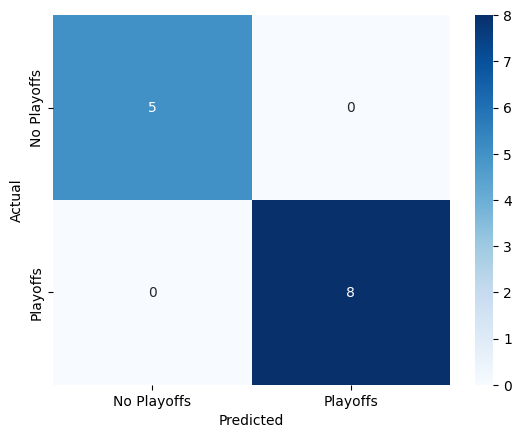

In [119]:
y_train = teams_train_df['playoff']
y_test = teams_test_df['playoff']
confIDs = teams_test_df['confID']
X_train = teams_train_df.drop(['playoff', 'year', 'tmID', 'firstRound', 'semis', 'finals', 'W_post', 'L_post'], axis=1)
X_test = teams_test_df.drop(['playoff', 'year', 'tmID', 'firstRound', 'semis', 'finals', 'W_post', 'L_post'], axis=1)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("X_test unique:" , X_test['confID'].unique())
print("y_test unique:" , y_test.unique())

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

clf = RandomForestClassifier()

y_pred = print_results(clf, X_train, X_test, y_train, y_test)

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 1.0
[[5 0]
 [0 8]]


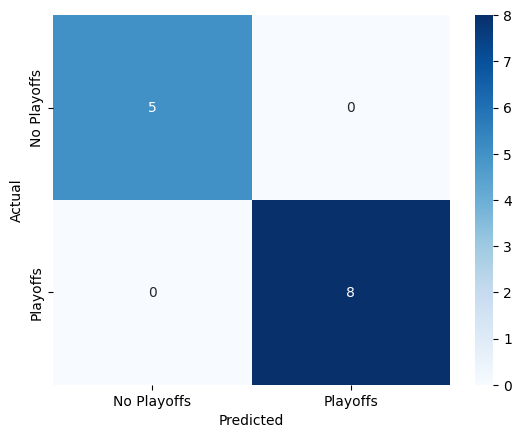

Cross-Validation Results:
Mean Accuracy: 98.62%
Standard Deviation: 0.03


In [120]:
force_qualify_8_teams(y_pred, y_test, confIDs)

scores = cross_validation(clf, X, y)
cross_val_scores.append(scores)

### KNN

Accuracy: 0.7692307692307693
[[2 3]
 [0 8]]


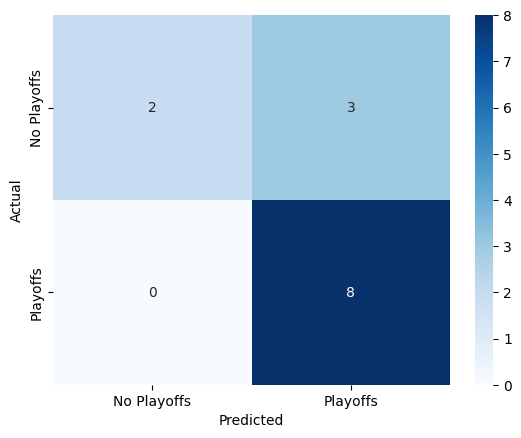

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 0.6923076923076923
[[3 2]
 [2 6]]


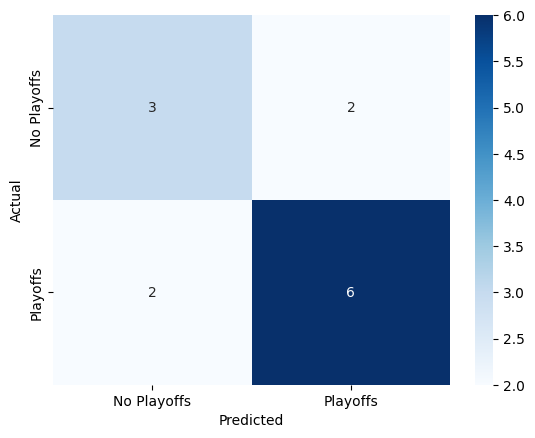

Cross-Validation Results:
Mean Accuracy: 83.10%
Standard Deviation: 0.08


In [121]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)

y_pred = print_results(knn_classifier, X_train, X_test, y_train, y_test)

force_qualify_8_teams(y_pred, y_test, confIDs)

scores = cross_validation(knn_classifier, X, y)
cross_val_scores.append(scores)

### Multinomial NaiveBayes

Accuracy: 0.7692307692307693
[[2 3]
 [0 8]]


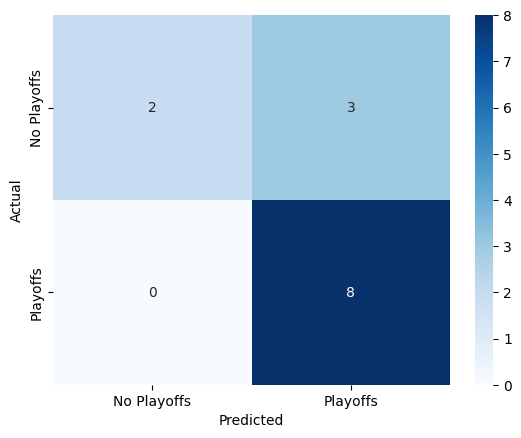

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 0.6923076923076923
[[3 2]
 [2 6]]


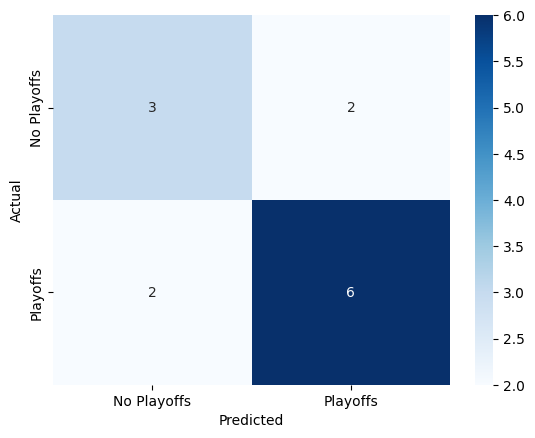

Cross-Validation Results:
Mean Accuracy: 92.29%
Standard Deviation: 0.06


In [122]:
mnb_classifier = MultinomialNB()

y_pred = print_results(knn_classifier, X_train, X_test, y_train, y_test)

force_qualify_8_teams(y_pred, y_test, confIDs)

scores = cross_validation(mnb_classifier, X, y)
cross_val_scores.append(scores)

### Neural Network

Accuracy: 0.6153846153846154
[[0 5]
 [0 8]]


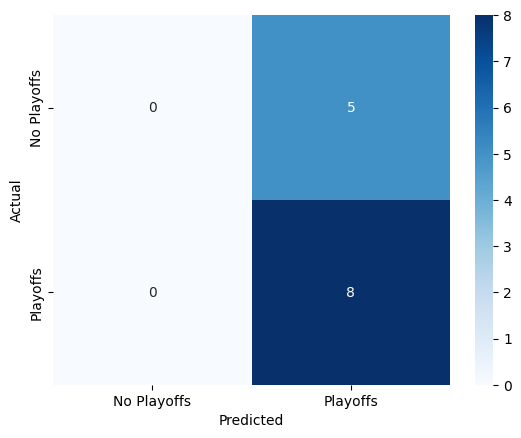

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 0.6923076923076923
[[3 2]
 [2 6]]


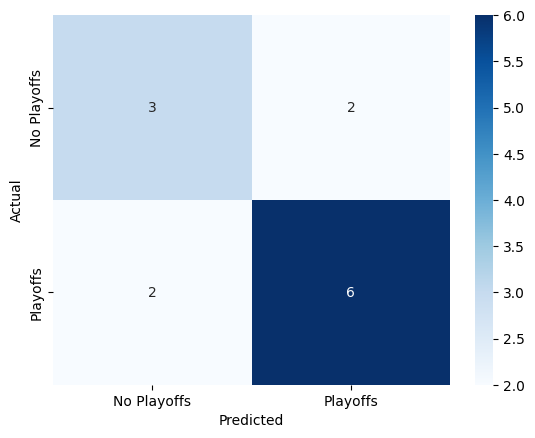

Cross-Validation Results:
Mean Accuracy: 87.19%
Standard Deviation: 0.24


In [123]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
    
y_pred = print_results(mlp_classifier, X_train, X_test, y_train, y_test)

force_qualify_8_teams(y_pred, y_test, confIDs)

scores = cross_validation(mlp_classifier, X, y)
cross_val_scores.append(scores)

### Gradient Boosting

Accuracy: 1.0
[[5 0]
 [0 8]]


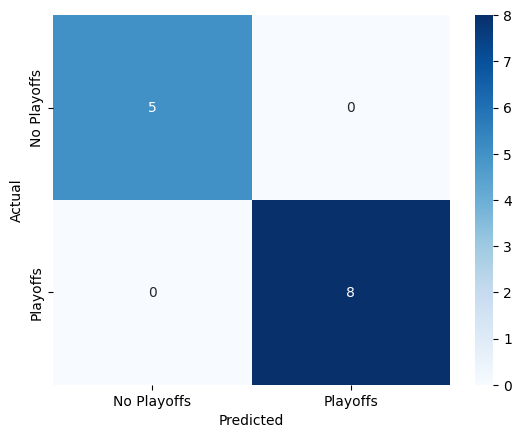

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 1.0
[[5 0]
 [0 8]]


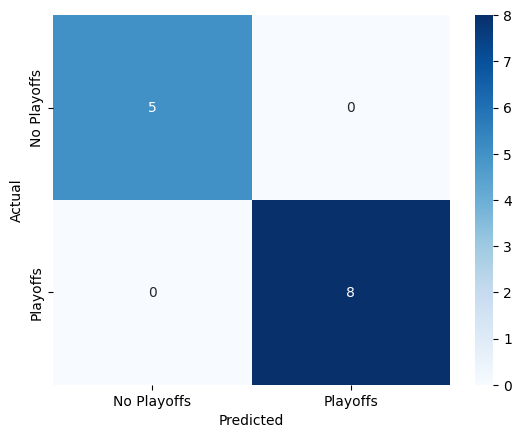

Cross-Validation Results:
Mean Accuracy: 100.00%
Standard Deviation: 0.00


In [124]:
xgboost_classifier = GradientBoostingClassifier(random_state=10)
    
y_pred = print_results(xgboost_classifier, X_train, X_test, y_train, y_test)

force_qualify_8_teams(y_pred, y_test, confIDs)

scores = cross_validation(xgboost_classifier, X, y)
cross_val_scores.append(scores)

### Conclusions

Using the current year information, the best model at their best. This permitted as to see which models will have a better performance with the data from the previous years, when we don't have the current year information.

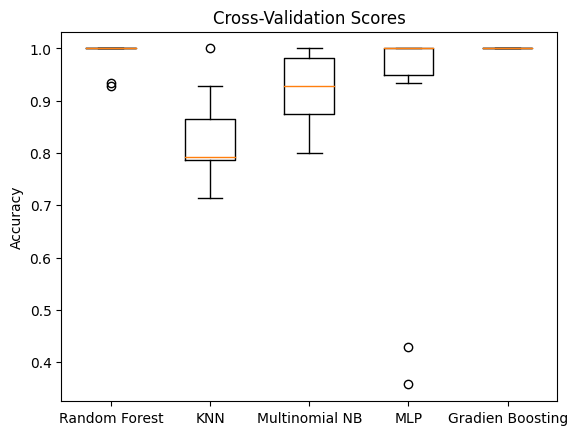

In [125]:
plt.boxplot(cross_val_scores, labels=['Random Forest', 'KNN', 'Multinomial NB', 'MLP', 'Gradien Boosting'])
plt.title('Cross-Validation Scores')
plt.ylabel('Accuracy')
plt.show()

The Random Forest Classifier seems to be performing better than the other classifiers.

In the next chapter we will explore using a rolling window to use past years for the predictions

## Rolling window

### Rolling window functions

We will use a rolling window to predict the next season. We will use the last 3 seasons to predict the next one.

In [154]:
# Define the rolling window size (number of past years to consider)
ROLLING_WIN_SIZE = 3  # You can adjust this value
PREDICTION_YEAR = 11

historical_data_df = teams_df[teams_df['year'] < PREDICTION_YEAR]

def create_rolling_window_dataset(df, rolling_win_size):
    '''This function creates a list of dataframes, where each 
    dataframe contains the data from the previous n years.
    It creates an entry for each year that the team has played.'''

    df_rolling = []
    for year in range(rolling_win_size + 1, PREDICTION_YEAR + 1):
        df_year = df[df['year'] == year]
        df_prev_years = df[(df['year'] < year) & (df['year'] >= year - rolling_win_size)]

        # Take the data into a df for each team
        for team in df_year['tmID'].unique():
            # Take the data from the previous years for the same team
            df_team_prev_years = df_prev_years[df_prev_years['tmID'] == team]

            # Add the dataframe to the list
            df_rolling.append(df_team_prev_years)

    return df_rolling

def generate_weights(window_size):
    weights = np.linspace(0.1, 1, window_size)
    weights /= weights.sum()  # Normalize weights to ensure they sum to 1
    return weights

Create the rolling window dataset.
In this dataset, three years are combined, with more weight given to the most recent year, and combining that historic data with the target variable (playoff) from the target year (the n+1 year)

In [152]:
def rolling_window_df():
    # Create the rolling window datasets
    rolling_window_historic = create_rolling_window_dataset(teams_df,  ROLLING_WIN_SIZE)

    weighted_features = ['o_fta', 'o_3pm', 'o_oreb', 'o_asts', 'o_stl', 'o_to', 'o_blk', 'd_3pa', 'd_oreb', 'd_dreb', 'd_asts', 'd_stl', 'd_to', 'd_blk', 'attend']
    weighted_features += ['total_blocks_weighted_mean', 'FG%_weighted_mean', 'FT%_weighted_mean', 'Avg_Rebounds_Per_Game_weighted_mean', 'Usability_weighted_mean', 'POSITION_METRIC_weighted_mean', 'num_trophies']

    # Create a new dataframe to store the rolling window data
    rolling_data = pd.DataFrame(columns=teams_df.columns)

    for window in rolling_window_historic:

        #Create a new empty line for the rolling_data dataframe
        rolling_data_line = pd.DataFrame(columns=teams_df.columns)

        if len(window) != 0:
            #1. Get the weights for the weighted average
            weights = generate_weights(len(window))

            #2. Get the weighted average of the weighted features
            #Note: The weighted average is calculated as follows:
            #weighted average = sum of (weight * feature value) / sum of weights
            #For example, if the weights are [0.2, 0.3, 0.5] and the feature values are [10, 20, 30], then the weighted average is:
            #weighted average = (0.2 * 10 + 0.3 * 20 + 0.5 * 30) / (0.2 + 0.3 + 0.5) = 24
            for feature in weighted_features:
                weighted_average = np.average(window[feature].values, weights=weights)
                rolling_data_line[feature] = [weighted_average]

            #3. Join that data with the data from the following year (the year we want to predict)
            #Note: The data from the following year will be used as the target label, get next year from the teams_df dataframe
            next_year = window['year'].max() + 1
            next_year_data = teams_df[(teams_df['tmID'] == window['tmID'].values[0]) & (teams_df['year'] == next_year)]

        #Add year, confID, tmID, and playoff columns
        try:
            rolling_data_line['year'] = next_year
            rolling_data_line['tmID'] = window['tmID'].values[0]
            rolling_data_line['confID'] = next_year_data['confID'].values[0]
            rolling_data_line['playoff'] = next_year_data['playoff'].values[0]
        except:
            #If there is no data for the next year, skip this line
            #print('No data for next year')
            continue
        
        #4. Concat the data to the rolling_data dataframe
        rolling_data = pd.concat([rolling_data, rolling_data_line])

    rolling_data = rolling_data.reset_index(drop=True)

    #5. Drop the columns with NA values
    #rolling_data = rolling_data.dropna(axis=1)

    return rolling_data

In [153]:
rolling_data = rolling_window_df()
#save rolling data to csv
rolling_data.to_csv('../debug_rolling_data.csv', index=False)

CHA
CLE
CON
DET
HOU
IND
LAS
MIN
NYL
PHO
SAC
SAS
SEA
WAS
CHA
CON
DET
HOU
IND
LAS
MIN
NYL
PHO
SAC
SAS
SEA
WAS
CHA
CON
DET
HOU
IND
LAS
MIN
NYL
PHO
SAC
SAS
SEA
WAS
CHA
CHI
CON
DET
HOU
IND
LAS
MIN
NYL
PHO
SAC
SAS
SEA
WAS
CHI
CON
DET
HOU
IND
LAS
MIN
NYL
PHO
SAC
SAS
SEA
WAS
ATL
CHI
CON
DET
HOU
IND
LAS
MIN
NYL
PHO
SAC
SAS
SEA
WAS
ATL
CHI
CON
DET
IND
LAS
MIN
NYL
PHO
SAC
SAS
SEA
WAS
SEA
WAS
LAS
MIN
PHO
SAS
TUL
ATL
CHI
CON
IND
NYL


### Random Forest with Rolling window

,confID,o_fta,o_3pm,o_oreb,o_asts,o_stl,o_to,o_blk,d_3pa,d_oreb,...,d_to,d_blk,attend,total_blocks_weighted_mean,FG%_weighted_mean,FT%_weighted_mean,Avg_Rebounds_Per_Game_weighted_mean,Usability_weighted_mean,POSITION_METRIC_weighted_mean,num_trophies
0,0,0.62,0.633,0.467,0.348,0.527,0.808,0.516,0.418,0.753,...,0.66,0.467,0.415,8.890518,0.399134,0.734591,3.393223,0.524892,0.356415,0.0
1,0,0.734152,0.344576,0.589,0.586606,0.430939,0.489545,0.471818,0.415424,0.584758,...,0.569697,0.425515,0.028,13.794946,0.400035,0.68467,3.973822,0.574258,0.375314,0.333333
2,0,0.388856,0.481301,0.462604,0.456018,0.453881,0.368947,0.400861,0.308545,0.444356,...,0.475652,0.240376,0.315962,14.042139,0.415005,0.741738,4.141399,0.606203,0.408944,0.19697
3,0,0.698611,0.292129,0.708033,0.540737,0.309596,0.577058,0.446922,0.505866,0.286389,...,0.498386,0.384341,0.466104,14.931606,0.404433,0.714851,5.213338,0.581409,0.45092,1.050505
4,0,0.360217,0.559601,0.47901,0.394217,0.661237,0.517311,0.403606,0.232391,0.263689,...,0.660091,0.424753,0.379144,13.657278,0.396182,0.749586,4.091527,0.58296,0.362146,0.848485


Accuracy: 0.8181818181818182
[[2 1]
 [1 7]]


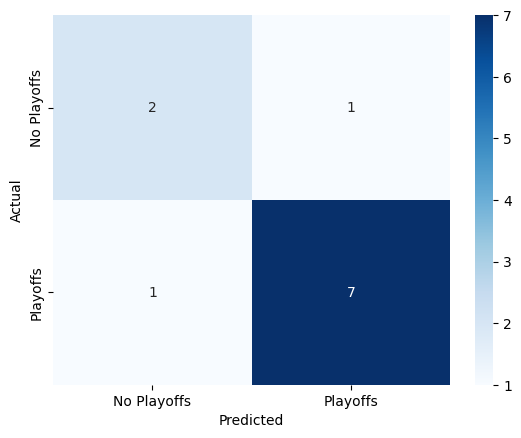

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 0.8181818181818182
[[2 1]
 [1 7]]


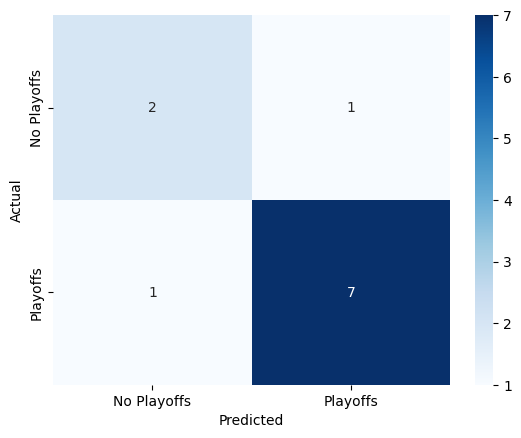

Cross-Validation Results:
Mean Accuracy: 85.00%
Standard Deviation: 0.23


In [146]:
y_train = rolling_data[rolling_data['year'] < PREDICTION_YEAR]['playoff'].astype(int)
y_test = rolling_data[rolling_data['year'] == PREDICTION_YEAR]['playoff'].astype(int)
confIDs = rolling_data[rolling_data['year'] == PREDICTION_YEAR]['confID']
X_train = rolling_data[rolling_data['year'] < PREDICTION_YEAR].drop(['playoff', 'year', 'tmID'], axis=1).dropna(axis=1)
X_test = rolling_data[rolling_data['year'] == PREDICTION_YEAR].drop(['playoff', 'year', 'tmID'], axis=1).dropna(axis=1)

clf = RandomForestClassifier(n_estimators=100)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

display(X_train.head())

y_pred = print_results(clf, X_train, X_test, y_train, y_test)

force_qualify_8_teams(y_pred, y_test, confIDs)

scores = cross_validation(clf, X, y)

## Grid Search

### Random Forest

Now, we will try to find what are the best parameters for the Random Forest, KNN and M Naive Bayes models, using Grid Search, and tune this models to see if we can improve the results.

In [130]:
#use grid search to find the best parameters
cross_val_scores = []
best_clf = {}
grid_search_params = {}
grid_search_models = {}

parameters = {'n_estimators': [10, 50, 100], 'max_depth': [9, 11, 13], 'max_features': ['sqrt', 'log2', 0.2], 'criterion': ['gini', 'entropy']}
clf = RandomForestClassifier()
grid_search_models['Random Forest'] = clf
grid_search_params['Random Forest'] = parameters

grid_search = GridSearchCV(clf, parameters, cv=5, scoring='accuracy', verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
clf = grid_search.best_estimator_
best_clf['Random Forest'] = (grid_search.best_score_, grid_search.best_estimator_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'n_estimators': 10}
0.7502923976608187
RandomForestClassifier(max_depth=9, max_features='log2', n_estimators=10)


Accuracy: 0.7272727272727273
[[3 0]
 [3 5]]


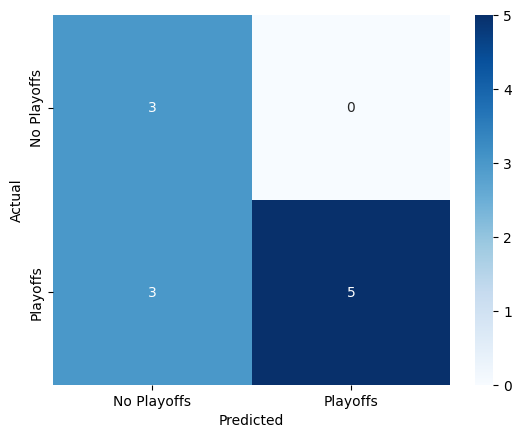

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 0.6363636363636364
[[1 2]
 [2 6]]


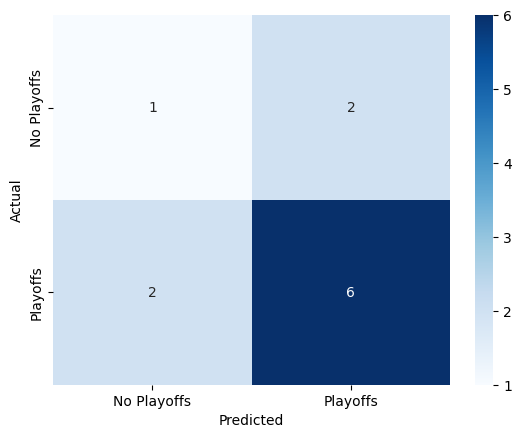

Cross-Validation Results:
Mean Accuracy: 66.00%
Standard Deviation: 0.12


In [131]:
# Use the best parameters to train the model
y_pred = print_results(clf, X_train, X_test, y_train, y_test)
force_qualify_8_teams(y_pred, y_test, confIDs)
scores = cross_validation(clf, X, y)
cross_val_scores.append(scores)

### KNN

In [132]:
# Use grid search to find the best parameters
parameters = {'n_neighbors': [3, 5, 7, 9, 11, 13], 'weights': ['uniform', 'distance']}
clf = KNeighborsClassifier()
grid_search_models['KNN'] = clf
grid_search_params['KNN'] = parameters

grid_search = GridSearchCV(clf, parameters, cv=5, scoring='accuracy', verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
clf = grid_search.best_estimator_
best_clf['KNN'] = (grid_search.best_score_, grid_search.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'n_neighbors': 3, 'weights': 'distance'}
0.7076023391812866
KNeighborsClassifier(n_neighbors=3, weights='distance')


Accuracy: 0.7272727272727273
[[1 2]
 [1 7]]


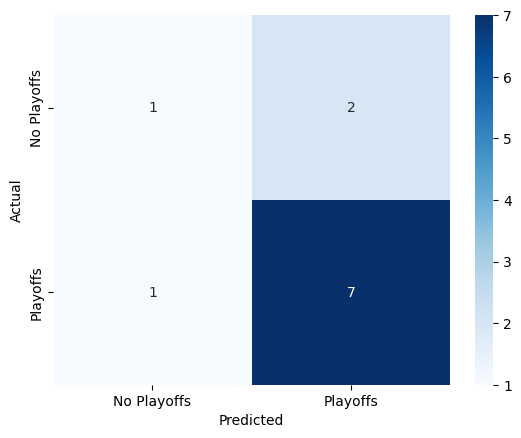

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 0.6363636363636364
[[1 2]
 [2 6]]


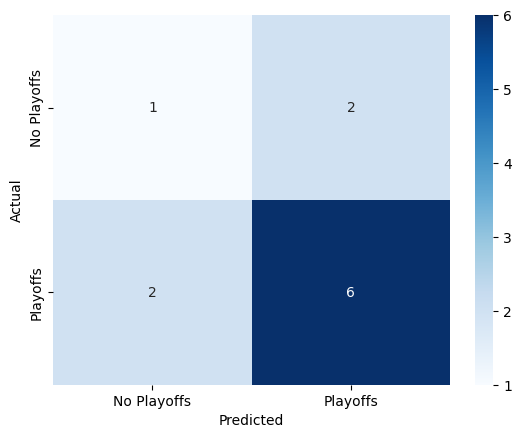

Cross-Validation Results:
Mean Accuracy: 73.64%
Standard Deviation: 0.14


In [133]:
#use the best parameters to train the model
y_pred = print_results(clf, X_train, X_test, y_train, y_test)
force_qualify_8_teams(y_pred, y_test, confIDs)
scores = cross_validation(clf, X, y)
cross_val_scores.append(scores)

### Multinomial NaiveBayes

In [134]:
#use grid search to find the best parameters
parameters = {'alpha': [0.1, 0.5, 1, 2, 5, 10]}
clf = MultinomialNB()
grid_search_models['Multinomial NB'] = clf
grid_search_params['Multinomial NB'] = parameters

grid_search = GridSearchCV(clf, parameters, cv=5, scoring='accuracy', verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
clf = grid_search.best_estimator_
best_clf['Multinomial NB'] = (grid_search.best_score_, grid_search.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'alpha': 0.5}
0.6087719298245614
MultinomialNB(alpha=0.5)


Accuracy: 0.7272727272727273
[[0 3]
 [0 8]]


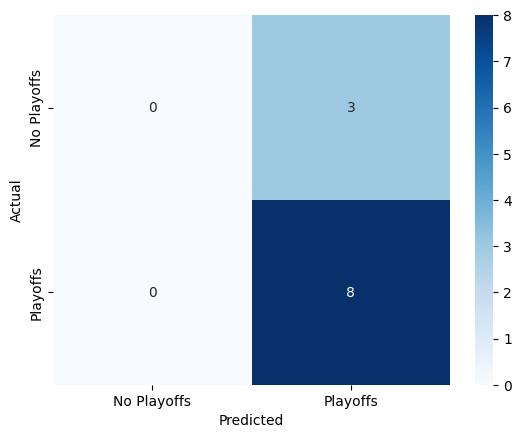

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 0.45454545454545453
[[0 3]
 [3 5]]


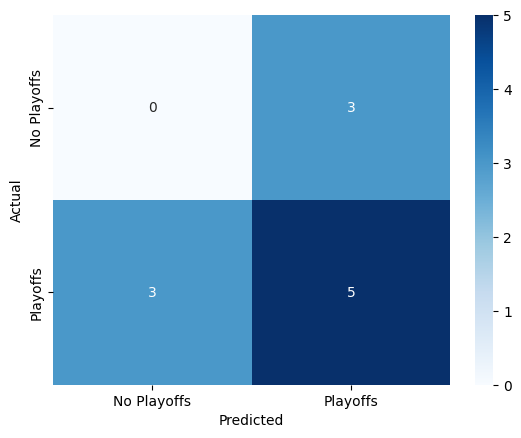

Cross-Validation Results:
Mean Accuracy: 62.09%
Standard Deviation: 0.03


In [135]:
#use the best parameters to train the model
y_pred = print_results(clf, X_train, X_test, y_train, y_test)
force_qualify_8_teams(y_pred, y_test, confIDs)
scores = cross_validation(clf, X, y)
cross_val_scores.append(scores)

### Gradient Boosting

In [136]:
parameters = {
    "learning_rate": [0.01, 0.1],
    "min_samples_split": np.linspace(0.1, 0.5, 2),
    "min_samples_leaf": np.linspace(0.1, 0.5, 2),
    "max_depth":[3,8],
    "max_features":["log2",None],
    "subsample":[0.8, 1.0],
    "n_estimators":[100]
}
clf = GradientBoostingClassifier()
grid_search_models['Gradient Boosting'] = clf
grid_search_params['Gradient Boosting'] = parameters

grid_search = GridSearchCV(clf, parameters, cv=5, scoring='accuracy', verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
clf = grid_search.best_estimator_
best_clf['Gradient Boosting'] = (grid_search.best_score_, grid_search.best_estimator_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


{'learning_rate': 0.01, 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 0.1, 'min_samples_split': 0.5, 'n_estimators': 100, 'subsample': 1.0}
0.7280701754385965
GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                           min_samples_leaf=0.1, min_samples_split=0.5)


Accuracy: 0.8181818181818182
[[1 2]
 [0 8]]


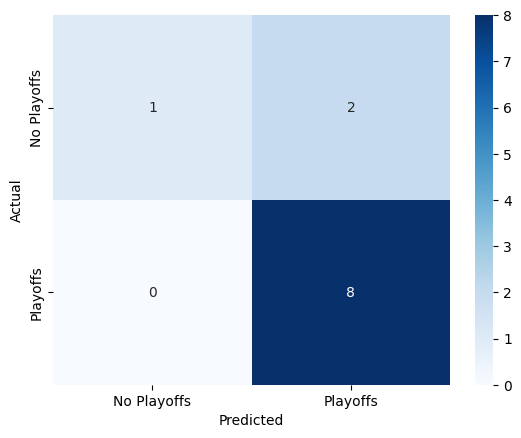

Modified Accuracy (Top 4 Teams from Each Conference as Playoff): 0.6363636363636364
[[1 2]
 [2 6]]


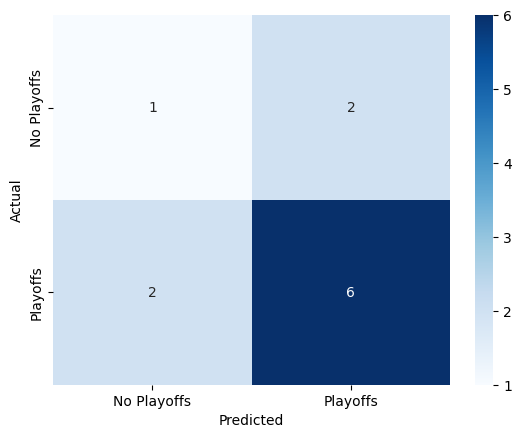

Cross-Validation Results:
Mean Accuracy: 66.91%
Standard Deviation: 0.11


In [137]:
#use the best parameters to train the model
y_pred = print_results(clf, X_train, X_test, y_train, y_test)
force_qualify_8_teams(y_pred, y_test, confIDs)
scores = cross_validation(clf, X, y)
cross_val_scores.append(scores)

### Plotting the results

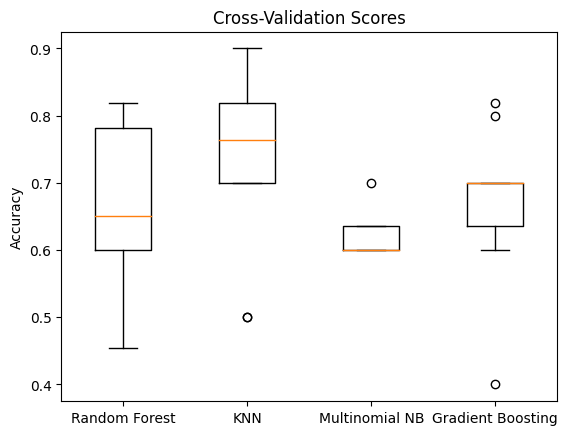

In [138]:
#plot the cross validation scores
plt.boxplot(cross_val_scores, labels=best_clf.keys())
plt.title('Cross-Validation Scores')
plt.ylabel('Accuracy') 
plt.show()

After getting our best classifier, we will try different numbers of ROLLING WINDOW to see if we can improve the results.

The best classifier is Random Forest with a score of 0.7502923976608187


{'whiskers': [<matplotlib.lines.Line2D at 0x22c7b05afa0>,
 'caps': [<matplotlib.lines.Line2D at 0x22c7b05a610>,
 'boxes': [<matplotlib.lines.Line2D at 0x22c7a958820>,
 'medians': [<matplotlib.lines.Line2D at 0x22c7b05a910>,
 'fliers': [<matplotlib.lines.Line2D at 0x22c7b0afdf0>,
 'means': []}

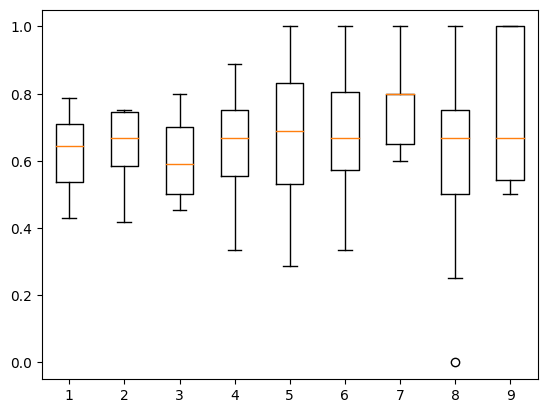

In [139]:
# Initialize variables to store the best score and estimator
best_score = -1
best_estimator = None
best_clf_name = None

# Iterate over the best_clf dictionary
for clf_name, (score, estimator) in best_clf.items():
    # If this classifier's score is higher than the current best score, update the best score and estimator
    if score > best_score:
        best_score = score
        best_estimator = estimator
        best_clf_name = clf_name

print(f"The best classifier is {best_clf_name} with a score of {best_score}")

cross_val_scores = []
for i in range(1, 10):
    ROLLING_WIN_SIZE = i
    rolling_data = rolling_window_df()

    y_train = rolling_data[rolling_data['year'] < PREDICTION_YEAR]['playoff'].astype(int)
    y_test = rolling_data[rolling_data['year'] == PREDICTION_YEAR]['playoff'].astype(int)
    confIDs = rolling_data[rolling_data['year'] == PREDICTION_YEAR]['confID']
    X_train = rolling_data[rolling_data['year'] < PREDICTION_YEAR].drop(['playoff', 'year', 'tmID'], axis=1).dropna(axis=1)
    X_test = rolling_data[rolling_data['year'] == PREDICTION_YEAR].drop(['playoff', 'year', 'tmID'], axis=1).dropna(axis=1)

    clf = best_estimator

    X = pd.concat([X_train, X_test])
    y = pd.concat([y_train, y_test])

    y_pred = print_results(clf, X_train, X_test, y_train, y_test, False)

    y_pred, y_test = force_qualify_8_teams(y_pred, y_test, confIDs, False)

    scores = cross_validation(clf, X, y, False)
    cross_val_scores.append(scores)

plt.boxplot(cross_val_scores, labels=['1', '2', '3', '4', '5', '6', '7', '8', '9'])

Now we will  use the other rolling window

{'criterion': 'gini', 'max_depth': 9, 'max_features': 0.2, 'n_estimators': 100}
1.0
RandomForestClassifier(max_depth=9, max_features=0.2)


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- finals
- firstRound
- semis


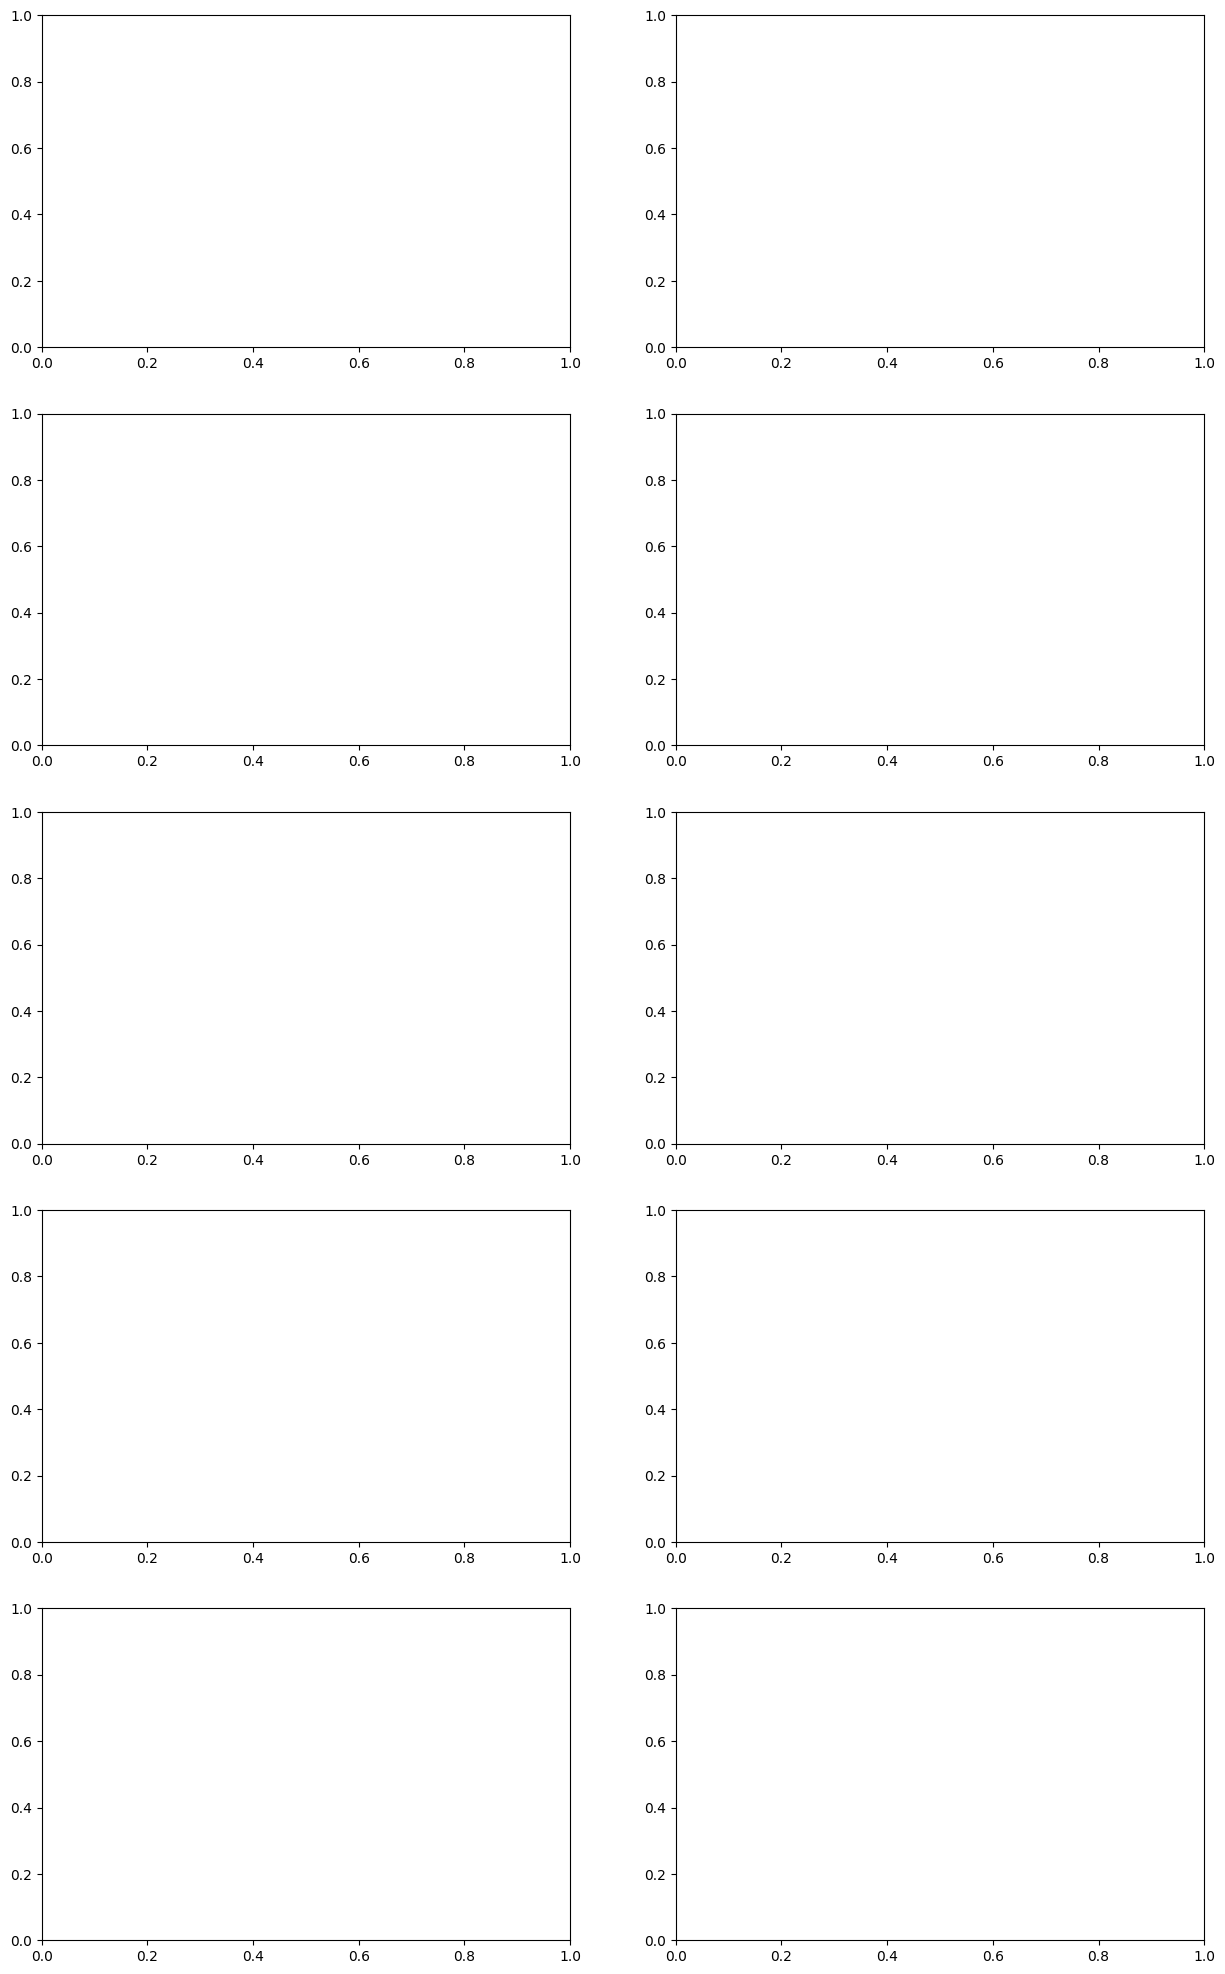

In [140]:
labels = []
cross_val_scores = []
best_clf = {}
fig, axs = plt.subplots(5, 2, figsize=(15, 25))

for i in range(1, 11):
    cross_val_scores_per_year = []
    labels_per_year = []
    rolling_data = pd.read_csv('../prep_data/rolling_window/data_with_' + str(i) +'_years_in_the_past.csv')

    y_train = rolling_data[rolling_data['year'] < PREDICTION_YEAR]['playoff'].astype(int)
    y_test = rolling_data[rolling_data['year'] == PREDICTION_YEAR]['playoff'].astype(int)
    confIDs = rolling_data[rolling_data['year'] == PREDICTION_YEAR]['confID']
    X_train = rolling_data[rolling_data['year'] < PREDICTION_YEAR].drop(['playoff', 'year', 'tmID'], axis=1).dropna(axis=1)
    X_test = rolling_data[rolling_data['year'] == PREDICTION_YEAR].drop(['playoff', 'year', 'tmID'], axis=1).dropna(axis=1)
    
    for model in grid_search_models.keys():
        clf = grid_search_models[model]
        parameters = grid_search_params[model]

        labels.append(model + '_w' + str(i) + 'years')
        labels_per_year.append(model + '_w' + str(i) + 'years')
        
        grid_search = GridSearchCV(clf, parameters, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        print(grid_search.best_params_)
        print(grid_search.best_score_)
        print(grid_search.best_estimator_)
        clf = grid_search.best_estimator_
        best_clf[model] = (grid_search.best_score_, grid_search.best_estimator_, [X_train, X_test, y_train, y_test, confIDs])

        X = pd.concat([X_train, X_test])
        y = pd.concat([y_train, y_test])

        y_pred = print_results(clf, X_train, X_test, y_train, y_test, False)

        force_qualify_8_teams(y_pred, y_test, confIDs, False)

        scores = cross_validation(clf, X, y, False)
        cross_val_scores.append(scores)
        cross_val_scores_per_year.append(scores)

    row = (i-1) // 2
    col = (i-1) % 2
    bp = axs[row, col].boxplot(cross_val_scores_per_year, labels=labels_per_year)
    axs[row, col].set_xticklabels(labels_per_year, rotation=60)
    axs[row, col].set_title('Rolling data size: ' +  str(i))
plt.subplots_adjust(hspace=1)

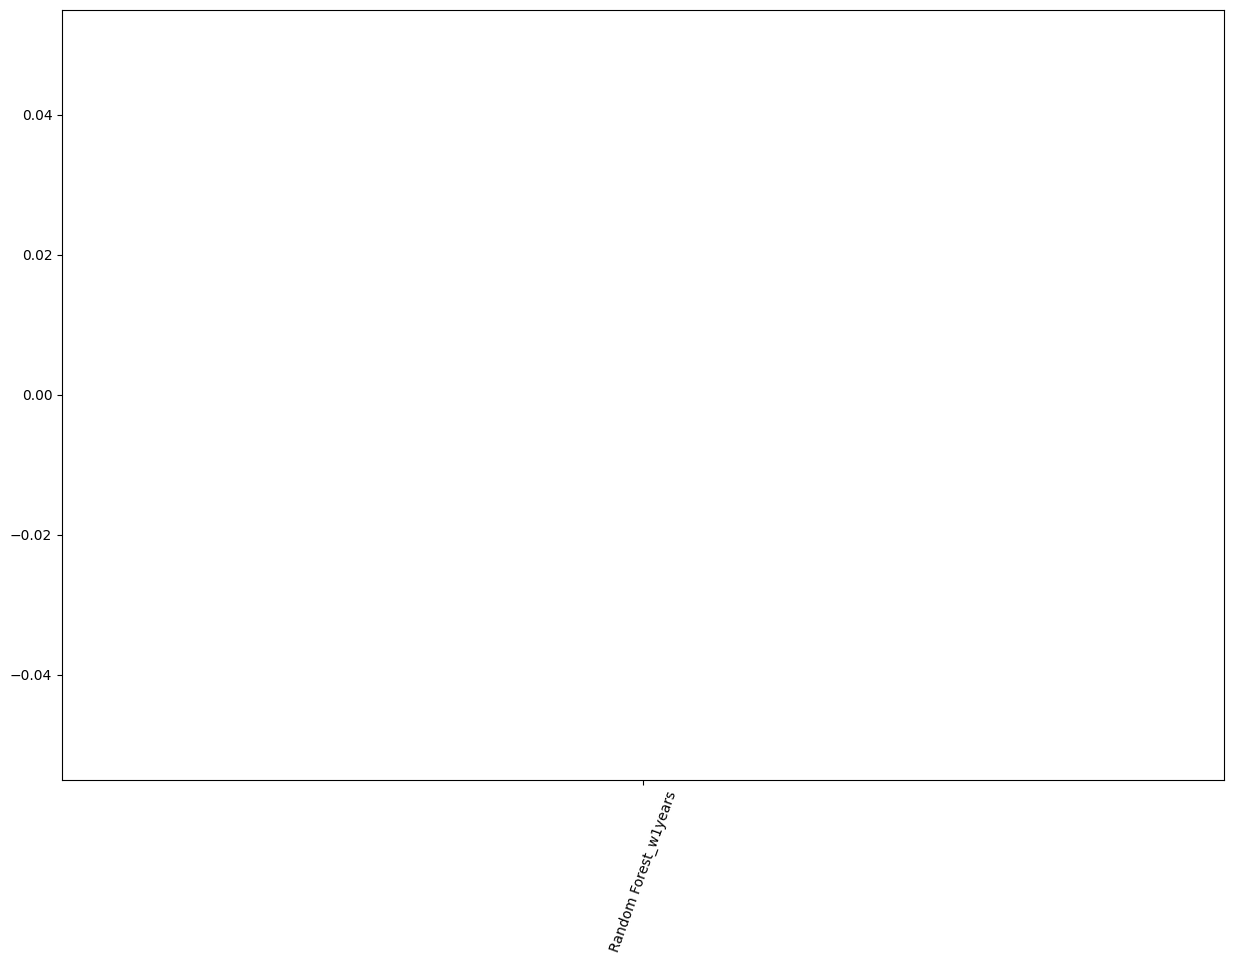

Random Forest( score: 1.0, estimator:RandomForestClassifier(max_depth=9, max_features=0.2))


In [142]:
plt.figure(figsize=(15, 10))
bp = plt.boxplot(cross_val_scores, labels=labels)
plt.xticks(rotation=70)
plt.show()

best_score = -1
best_classifier = None
for best_name, best in best_clf.items():
    print(best_name + '( score: ' + str(best[0]) + ', estimator:' + str(best[1]) + ')')

    if best[0] > best_score:
        best_score = best[0]
        best_classifier = best

In [143]:
competition_data = pd.read_csv('../prep_data/rolling_window/data_with_' + str(1) +'_years_in_the_past.csv')

with open('results.txt', 'w') as f:
    y_pred = print_results(best_classifier[1], best_classifier[2][0], best_classifier[2][1], best_classifier[2][2], best_classifier[2][3])
    force_qualify_8_teams(y_pred, best_classifier[2][3], best_classifier[2][4])
    scores = cross_validation(best_classifier[1], X, y)
    y_pred_df = pd.DataFrame(y_pred, columns=['playoff'])
    competition_data = competition_data[rolling_data['year'] == PREDICTION_YEAR][['tmID', 'year', 'confID']] # wrong? with force_qualify_8_teams they disordered
    result = competition_data.join(y_pred_df)
    f.write(str(competition_data))

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- finals
- firstRound
- semis
